In [15]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch

import matplotlib.pyplot as plt

import ase.io

from utils.soap import compute_spherical_expansion_librascal, PowerSpectrum
from utils.gap import train_gap_model
from utils.alchemical import AlchemicalCombine

torch.set_default_dtype(torch.float64)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
frames = ase.io.read("data/elpasolites_10590.xyz", ":300")
energies = torch.tensor(np.loadtxt("data/elpasolites_10590_evpa.dat")[:300])

train_frames = frames[:250]
test_frames = frames[250:]

train_energies = energies[:250]
test_energies = energies[250:]

In [17]:
global_species = set()
for frame in frames:
    global_species.update(frame.numbers)

global_species = list(map(lambda u: int(u), global_species))

HYPERS = {
    "interaction_cutoff": 5.0,
    "max_angular": 4,
    "max_radial": 4,
    "gaussian_sigma_constant": 0.3,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.5,
    "radial_basis": "GTO",
    "compute_gradients": False,
    "expansion_by_species_method": "user defined",
    "global_species": global_species,
}

In [18]:
train_spherical_expansions = compute_spherical_expansion_librascal(train_frames, HYPERS)
test_spherical_expansions = compute_spherical_expansion_librascal(test_frames, HYPERS)

train_species = [torch.tensor(frame.numbers) for frame in train_frames]
test_species = [torch.tensor(frame.numbers) for frame in test_frames]

# Baseline: standard GAP model

In [19]:
class BaseGap(torch.nn.Module):
    def __init__(self, n_support, zeta, lambdas):
        super().__init__()
        self.power_spectrum = PowerSpectrum()

        self.n_support = n_support
        self.zeta = zeta
        self.lambdas = lambdas

        self.model = None

    def fit(self, spherical_expansion, all_species, energies):
        power_spectrum = [
            self.power_spectrum(se) for se in spherical_expansion
        ]
        self.model = train_gap_model(
            power_spectrum, 
            all_species,
            energies, 
            self.n_support, 
            zeta=self.zeta, 
            lambdas=self.lambdas
        )

    def forward(self, spherical_expansion, all_species):
        ps = self.power_spectrum(spherical_expansion)
        return self.model(ps, all_species)

In [20]:
n_support = {
    species: 10 for species in global_species
}

base_model = BaseGap(n_support, zeta=2, lambdas=[1e-6, 1e-6])
base_model.fit(train_spherical_expansions, train_species, train_energies)

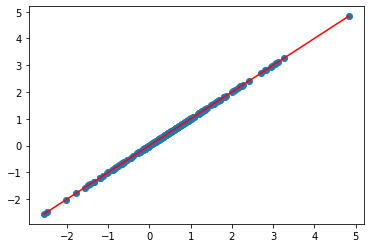

In [21]:
predicted_energies_training_set = torch.vstack([
    base_model(se, sp)
    for se, sp in zip(train_spherical_expansions, train_species)
])

plt.scatter(predicted_energies_training_set.numpy(), train_energies)

x = np.linspace(train_energies.min(), train_energies.max(), 20)
plt.plot(x, x, color='r')

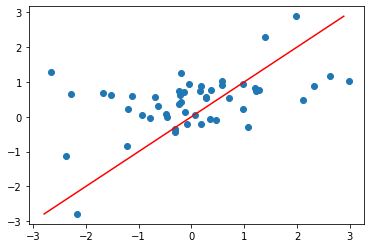

In [22]:
predicted_energies_test_set = torch.vstack([
    base_model(se, sp)
    for se, sp in zip(test_spherical_expansions, test_species)
])

plt.scatter(predicted_energies_test_set.numpy(), test_energies)

x = np.linspace(test_energies.min(), test_energies.max(), 20)
plt.plot(x, x, color='r')

# Combining species

In [23]:
class MixedSpeciesGap(torch.nn.Module):
    def __init__(self, species, n_pseudo_species, n_support, zeta, lambdas):
        super().__init__()
        self.power_spectrum = PowerSpectrum()
        self.alchemical = AlchemicalCombine(species, n_pseudo_species)

        self.n_support = n_support
        self.zeta = zeta
        self.lambdas = lambdas

        self.model = None

    def fit(self, spherical_expansion, all_species, energies):
        combined = [
            self.alchemical(se) for se in spherical_expansion
        ]

        power_spectrum = [
            self.power_spectrum(se) for se in combined
        ]
        self.model = train_gap_model(
            power_spectrum, 
            all_species,
            energies, 
            self.n_support, 
            zeta=self.zeta, 
            lambdas=self.lambdas
        )

    def forward(self, spherical_expansion, all_species):
        combined = self.alchemical(spherical_expansion)
        ps = self.power_spectrum(combined)
        return self.model(ps, all_species)

In [24]:
mixed_species_model = MixedSpeciesGap(global_species, n_pseudo_species=4, n_support=n_support, zeta=2, lambdas=[1e-6, 1e-6])
mixed_species_model.fit(train_spherical_expansions, train_species, train_energies)

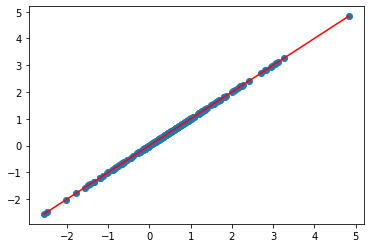

In [25]:
predicted_energies_training_set = torch.vstack([
    mixed_species_model(se, sp)
    for se, sp in zip(train_spherical_expansions, train_species)
])

plt.scatter(predicted_energies_training_set.detach().numpy(), train_energies)

x = np.linspace(train_energies.min(), train_energies.max(), 20)
plt.plot(x, x, color='r')

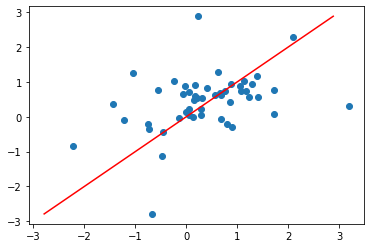

In [26]:
predicted_energies_test_set = torch.vstack([
    mixed_species_model(se, sp)
    for se, sp in zip(test_spherical_expansions, test_species)
])

plt.scatter(predicted_energies_test_set.detach().numpy(), test_energies)

x = np.linspace(test_energies.min(), test_energies.max(), 20)
plt.plot(x, x, color='r')

In [ ]:
# tentative optimization loop for the species projection

mixed_species_model = MixedSpeciesGap(global_species, n_pseudo_species=4, n_support=n_support, zeta=2, lambdas=[1e-6, 1e-6])

optimizer = torch.optim.AdamW(mixed_species_model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

for epoch in range(300):
    optimizer.zero_grad()

    mixed_species_model.fit(train_spherical_expansions, train_species, train_energies)
    predicted = torch.vstack([
        mixed_species_model(se, sp)
        for se, sp in zip(train_spherical_expansions, train_species)
    ])

    loss = loss_fn(predicted.squeeze(), train_energies)

    if epoch % 10 == 0:
        print(epoch, loss.item())

    loss.backward()
    optimizer.step()
